# Лабораторная работа 1  
### Планирование пути агента в 2D-среде с помощью A*

## Постановка задачи

**Цель работы.**  
Реализовать агента, который планирует путь в двумерной среде с препятствиями, используя алгоритм A\*.  
Агент должен уметь находить и визуально демонстрировать движение по коллизионно-свободному пути от начальной точки к целевой.

In [31]:
import heapq
import math
from collections import deque

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation
from IPython.display import HTML

In [32]:
# Grid environment and heuristics
FREE = 0  # free cell
OBST = 1  # obstacle cell


def manhattan(a, b):
    """Manhattan distance between two grid cells (4-connected heuristic)."""
    return abs(a[0] - b[0]) + abs(a[1] - b[1])


def euclidean(a, b):
    """Euclidean distance between two grid cells."""
    return math.sqrt((a[0] - b[0]) ** 2 + (a[1] - b[1]) ** 2)


def diagonal_distance(a, b):
    """
    Diagonal distance (Chebyshev metric), good for 8-connected movement.
    max(dx, dy)
    """
    return max(abs(a[0] - b[0]), abs(a[1] - b[1]))


class GridWorld:

    def __init__(self, grid, start, goal):
        self.grid = np.array(grid, dtype=int)
        self.start = tuple(start)
        self.goal = tuple(goal)
        self.rows, self.cols = self.grid.shape

    def in_bounds(self, cell):
        """Check if a cell is inside the grid."""
        r, c = cell
        return 0 <= r < self.rows and 0 <= c < self.cols

    def passable(self, cell):
        """Check if a cell is not an obstacle."""
        r, c = cell
        return self.grid[r, c] == FREE

    def neighbors(self, cell, diagonal=False):
        """
        Get neighbor cells of a given cell.

        Parameters
        ----------
        cell : tuple[int, int]
            Current cell (row, col).
        diagonal : bool
            If True, allow 8-connected movement (with diagonals).

        Returns
        -------
        list[tuple[int, int]]
            List of neighboring cells that are inside the grid and free.
        """
        if diagonal:
            steps = [
                (1, 0), (-1, 0), (0, 1), (0, -1),
                (1, 1), (1, -1), (-1, 1), (-1, -1)
            ]
        else:
            steps = [(1, 0), (-1, 0), (0, 1), (0, -1)]

        result = []
        for dr, dc in steps:
            nr, nc = cell[0] + dr, cell[1] + dc
            neighbor = (nr, nc)
            if self.in_bounds(neighbor) and self.passable(neighbor):
                result.append(neighbor)
        return result

In [33]:
# A* search implementation

def astar_search(env, heuristic=manhattan, diagonal=False):
    """
    Run A* search on a GridWorld environment.

    Parameters
    ----------
    env : GridWorld
        Environment instance.
    heuristic : callable
        Heuristic function h(n, goal). Should take two cell tuples.
    diagonal : bool
        If True, use 8-connected movement.

    Returns
    -------
    path : list[tuple[int, int]] or None
        Shortest path from start to goal (inclusive), or None if no path.
    visited_order : list[tuple[int, int]]
        Order in which cells were popped from the priority queue (for visualization).
    """
    start, goal = env.start, env.goal

    # Priority queue of (f_score, g_score, cell)
    open_set = []
    heapq.heappush(open_set, (heuristic(start, goal), 0.0, start))

    came_from = {}         # parent pointer for path reconstruction
    g_score = {start: 0.0} # cost from start to each cell
    visited_order = []     # track expansion order
    closed = set()

    while open_set:
        f, g, current = heapq.heappop(open_set)

        if current in closed:
            continue

        visited_order.append(current)

        if current == goal:
            # Reconstruct path
            path = [current]
            while current in came_from:
                current = came_from[current]
                path.append(current)
            path.reverse()
            return path, visited_order

        closed.add(current)

        for neighbor in env.neighbors(current, diagonal=diagonal):
            step_cost = euclidean(current, neighbor) if diagonal else 1.0
            tentative_g = g_score[current] + step_cost

            if tentative_g < g_score.get(neighbor, math.inf):
                g_score[neighbor] = tentative_g
                came_from[neighbor] = current
                f_score = tentative_g + heuristic(neighbor, goal)
                heapq.heappush(open_set, (f_score, tentative_g, neighbor))

    # No path found
    return None, visited_order

In [34]:
# Breadth-First Search (BFS) for comparison

def bfs_search(env, diagonal=False):
    """
    Breadth-First Search in GridWorld (unweighted graph).

    Parameters
    ----------
    env : GridWorld
        Environment instance.
    diagonal : bool
        If True, use 8-connected neighbors.

    Returns
    -------
    path : list[tuple[int, int]] or None
        Shortest path in terms of number of steps, or None.
    visited_order : list[tuple[int, int]]
        Order of node expansions.
    """
    start, goal = env.start, env.goal
    queue = deque([start])
    came_from = {start: None}
    visited_order = []
    visited = set([start])

    while queue:
        current = queue.popleft()
        visited_order.append(current)

        if current == goal:
            # reconstruct path
            path = []
            while current is not None:
                path.append(current)
                current = came_from[current]
            path.reverse()
            return path, visited_order

        for neighbor in env.neighbors(current, diagonal=diagonal):
            if neighbor not in visited:
                visited.add(neighbor)
                came_from[neighbor] = current
                queue.append(neighbor)

    return None, visited_order

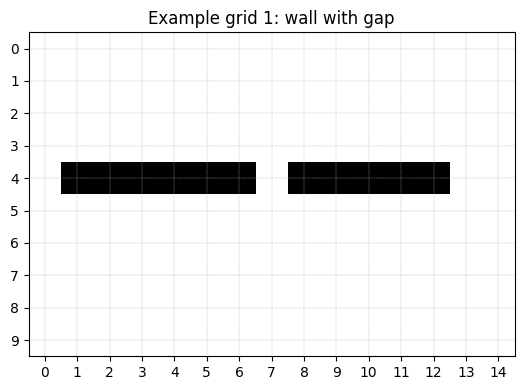

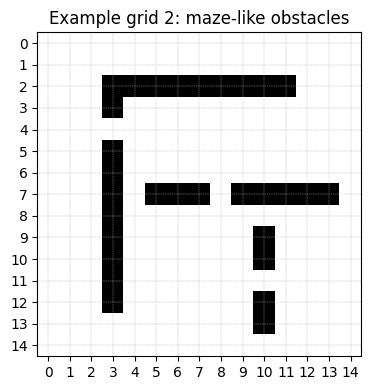

In [35]:
# Grid visualization helper

def plot_grid(env, path=None, visited=None, title="GridWorld"):

    grid = env.grid
    rows, cols = grid.shape

    fig, ax = plt.subplots(figsize=(6, 4))
    # 1 = obstacle (dark), 0 = free (light)
    im = ax.imshow(grid, cmap="Greys", origin="upper")

    # Plot visited cells (if provided)
    if visited is not None:
        ys = [c[0] for c in visited]
        xs = [c[1] for c in visited]
        ax.scatter(xs, ys, s=15, alpha=0.4, label="Visited")

    # Plot path (if provided)
    if path is not None and len(path) > 0:
        ys = [c[0] for c in path]
        xs = [c[1] for c in path]
        ax.plot(xs, ys, linewidth=2, label="Path")
        # Mark start and goal
        ax.scatter(xs[0], ys[0], s=60, marker="o", label="Start")
        ax.scatter(xs[-1], ys[-1], s=60, marker="x", label="Goal")

    ax.set_xticks(range(cols))
    ax.set_yticks(range(rows))
    ax.set_xlim(-0.5, cols - 0.5)
    ax.set_ylim(rows - 0.5, -0.5)
    ax.grid(True, linestyle="--", linewidth=0.3)
    ax.set_title(title)

    # Only show legend if there are labeled artists
    handles, labels = ax.get_legend_handles_labels()
    if handles:
        ax.legend(loc="upper right")

    plt.tight_layout()
    plt.show()


# Example maps

def example_grid_1():
    """Simple obstacle wall with a gap."""
    grid = np.zeros((10, 15), dtype=int)
    # Horizontal wall with one small gap
    grid[4, 1:13] = OBST
    grid[4, 7] = FREE  # create a small gap in the wall
    start = (0, 0)
    goal = (9, 14)
    return GridWorld(grid, start, goal)


def example_grid_2():
    """More complex maze-like obstacles."""
    grid = np.zeros((15, 15), dtype=int)
    # Create some walls
    grid[2:13, 3] = OBST
    grid[2, 3:12] = OBST
    grid[7, 5:14] = OBST
    grid[9:14, 10] = OBST
    # Carve some gaps to ensure connectivity
    grid[4, 3] = FREE
    grid[7, 8] = FREE
    grid[11, 10] = FREE

    start = (0, 0)
    goal = (14, 14)
    return GridWorld(grid, start, goal)


# Create environments and visualize them
env1 = example_grid_1()
env2 = example_grid_2()

plot_grid(env1, title="Example grid 1: wall with gap")
plot_grid(env2, title="Example grid 2: maze-like obstacles")


A* (4-connected): path length = 24 visited nodes = 139
A* (8-connected): path length = 15 visited nodes = 62
BFS (4-connected): path length = 24 visited nodes = 139


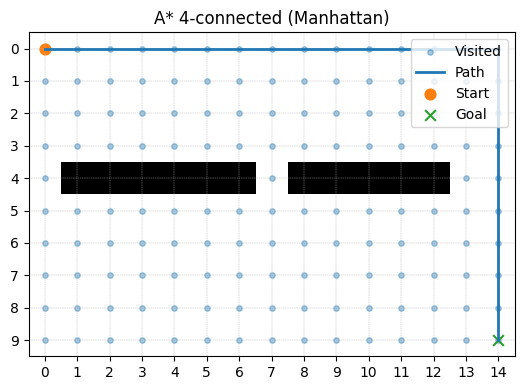

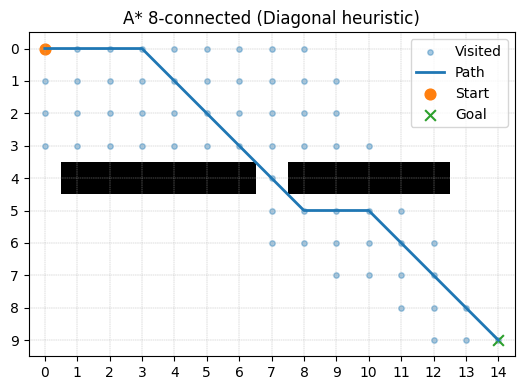

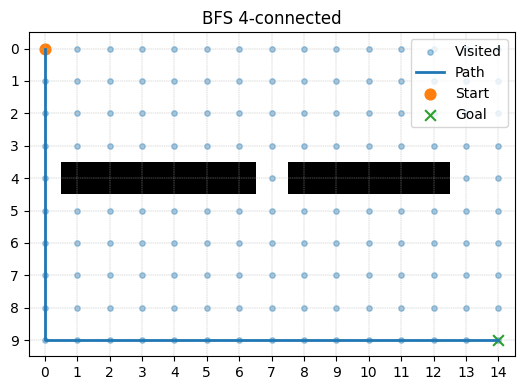

In [36]:
# Run A* and BFS on the first example grid
env = env1

# A* with 4-connected movement and Manhattan heuristic
path_astar_4, visited_astar_4 = astar_search(env, heuristic=manhattan, diagonal=False)

# A* with 8-connected movement and diagonal heuristic
path_astar_8, visited_astar_8 = astar_search(env, heuristic=diagonal_distance, diagonal=True)

# BFS with 4-connected movement
path_bfs_4, visited_bfs_4 = bfs_search(env, diagonal=False)

print("A* (4-connected): path length =", len(path_astar_4) if path_astar_4 else None,
      "visited nodes =", len(visited_astar_4))
print("A* (8-connected): path length =", len(path_astar_8) if path_astar_8 else None,
      "visited nodes =", len(visited_astar_8))
print("BFS (4-connected): path length =", len(path_bfs_4) if path_bfs_4 else None,
      "visited nodes =", len(visited_bfs_4))

plot_grid(env, path_astar_4, visited_astar_4, title="A* 4-connected (Manhattan)")
plot_grid(env, path_astar_8, visited_astar_8, title="A* 8-connected (Diagonal heuristic)")
plot_grid(env, path_bfs_4, visited_bfs_4, title="BFS 4-connected")

In [37]:
# # Animation: agent walking along the A* path

# def animate_agent(env, path, interval=200):
#     """
#     Animate an agent moving along a given path on the grid.

#     Parameters
#     ----------
#     env : GridWorld
#         Environment.
#     path : list[tuple[int, int]]
#         Path as a sequence of (row, col) cells.
#     interval : int
#         Delay between frames in milliseconds.

#     """
#     grid = env.grid
#     rows, cols = grid.shape

#     fig, ax = plt.subplots(figsize=(5, 4))
#     ax.imshow(grid, cmap="Greys", origin="upper")
#     ax.set_xticks(range(cols))
#     ax.set_yticks(range(rows))
#     ax.set_xlim(-0.5, cols - 0.5)
#     ax.set_ylim(rows - 0.5, -0.5)
#     ax.grid(True, linestyle="--", linewidth=0.3)
#     ax.set_title("Agent moving along path (A*)")

#     # Plot start and goal
#     ax.scatter(env.start[1], env.start[0], c="green", s=60, marker="o", label="Start")
#     ax.scatter(env.goal[1], env.goal[0], c="purple", s=60, marker="x", label="Goal")
#     ax.legend(loc="upper right")

#     # Initialize agent marker
#     agent_scatter = ax.scatter([], [], c="tab:red", s=80, marker="o")

#     def init():
#         agent_scatter.set_offsets([[0, 0]])
#         return (agent_scatter,)

#     def update(frame):
#         cell = path[frame]
#         # set_offsets expects [[x, y]]
#         agent_scatter.set_offsets([[cell[1], cell[0]]])
#         return (agent_scatter,)

#     anim = animation.FuncAnimation(
#         fig,
#         update,
#         init_func=init,
#         frames=len(path),
#         interval=interval,
#         blit=True,
#     )
#     plt.close(fig)
#     return HTML(anim.to_jshtml())


# # Choose path to animate (for example, A* 8-connected)
# if path_astar_8 is not None:
#     animate_agent(env, path_astar_8, interval=150)
# else:
#     print("No path found to animate.")

In [38]:
# # Test the algorithms on the second, more complex grid

# env = env2

# path_astar_8_e2, visited_astar_8_e2 = astar_search(env, heuristic=diagonal_distance, diagonal=True)
# path_bfs_4_e2, visited_bfs_4_e2 = bfs_search(env, diagonal=False)

# print("[Env2] A* (8-connected): path length =", len(path_astar_8_e2) if path_astar_8_e2 else None,
#       "visited nodes =", len(visited_astar_8_e2))
# print("[Env2] BFS (4-connected): path length =", len(path_bfs_4_e2) if path_bfs_4_e2 else None,
#       "visited nodes =", len(visited_bfs_4_e2))

# plot_grid(env, path_astar_8_e2, visited_astar_8_e2, title="Env2: A* 8-connected (Diagonal heuristic)")
# plot_grid(env, path_bfs_4_e2, visited_bfs_4_e2, title="Env2: BFS 4-connected")

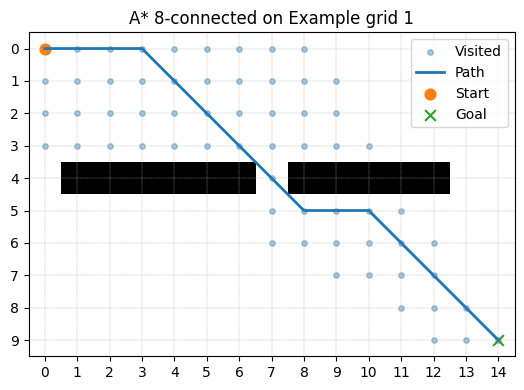

In [39]:
env = env1

path_astar_8_env1, visited_astar_8_env1 = astar_search(
    env, heuristic=diagonal_distance, diagonal=True
)

plot_grid(env, path_astar_8_env1, visited_astar_8_env1,
          title="A* 8-connected on Example grid 1")

if path_astar_8_env1 is not None:
    anim_html = animate_agent(env, path_astar_8_env1, interval=200)
    display(anim_html)
else:
    print("No path found on env1.")

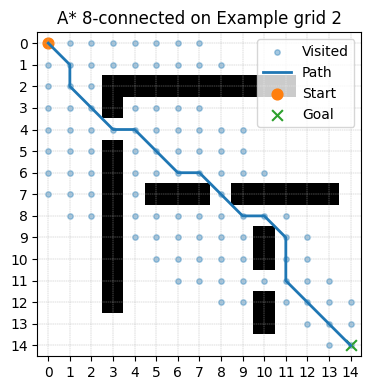

In [40]:
env = env2

path_astar_8_env2, visited_astar_8_env2 = astar_search(
    env, heuristic=diagonal_distance, diagonal=True
)

plot_grid(env, path_astar_8_env2, visited_astar_8_env2,
          title="A* 8-connected on Example grid 2")

if path_astar_8_env2 is not None:
    anim_html = animate_agent(env, path_astar_8_env2, interval=300)
    display(anim_html)
else:
    print("No path found on env2.")



1. **Сравнение A\* и BFS**
   - BFS всегда находит кратчайший путь по числу шагов, но не использует информацию о целевой точке и часто просматривает много лишних узлов.
   - A\* использует эвристику (оценку расстояния до цели), поэтому, как правило, приходит к цели с меньшим числом просмотренных ячеек.
   - В примерах видно, что A\* посещает меньше узлов при сопоставимой длине пути (или таком же кратчайшем пути).

2. **Когнитивная архитектура (упрощённый взгляд)**
   - **Внутреннее представление мира**: карта окружения (grid), где агент хранит информацию о препятствиях и свободных клетках.
   - **Модуль планирования**: алгоритм A\* строит план (последовательность состояний/клеток) от текущего состояния к цели.
   - **Модуль поведения**: анимация демонстрирует, как агент последовательно следует найденному плану (path) до достижения цели.
   - Такая схема соответствует базовой идее когнитивной архитектуры: perception → internal model → planning → action.

3. **Ограничения модели**
   - Дискретное пространство (решётка), нет учёта динамики движения, скоростей, инерции и т.п.
   - Среда статична: препятствия не меняются во времени, нет других агентов.
   - Эвристика выбрана вручную, нет обучения.

4. **Возможные расширения**
   - Добавить динамические препятствия и перерасчёт пути в реальном времени.
   - Перейти от решётки к непрерывному пространству и использовать sampling-based методы (RRT и др.).
   - Связать модуль A\* с более богатыми когнитивными архитектурами, где планирование комбинируется с обучением, памятью и высокоуровневым рассуждением.